# All used datasets - summary

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [8]:
from src.settings import DATA_DIR, FIGURE_DIR

GOEMOTIONS_DIR = DATA_DIR.joinpath('goemotions')
MOVIE_REVIEWS_DIR = DATA_DIR.joinpath('movie_reviews')
IMDB_DIR = DATA_DIR.joinpath('imdb')
KLEJ_AR_DIR = DATA_DIR.joinpath('klej_ar')
SST_DIR = DATA_DIR.joinpath('stanford_treebank')
POLEMO_DIR = DATA_DIR.joinpath('polemo2')
MULTIEMO_DIR = DATA_DIR.joinpath('multiemo')

In [27]:
from pathlib import Path


def get_all_frame_polemo(path: Path, domain: str, mode: str, split: str, text_col: str, label_col: str):
    path = path.joinpath('origin', f'{domain}.{mode}.{split}.txt')
    with path.open() as f:
        lines = f.readlines()

    texts = []
    labels = []

    for line in lines:
        text, label = line.split('__label__meta_')
        labels.append(label.rstrip('\n'))
        texts.append(text.strip())

    return pd.DataFrame(list(zip(texts, labels)), columns=[text_col, label_col])


def get_all_frame(path: Path, text_col: str, label_col: str) -> pd.DataFrame:
    if 'polemo2' in path.__str__():
        df_train = get_all_frame_polemo(
            path=path, domain='all', mode='text', split='train', text_col=text_col, label_col=label_col,
        )
        df_val = get_all_frame_polemo(
            path=path, domain='all', mode='text', split='dev', text_col=text_col, label_col=label_col,
        )
        df_test = get_all_frame_polemo(
            path=path, domain='all', mode='text', split='test', text_col=text_col, label_col=label_col,
        )
    else:
        df_train = pd.read_csv(path.joinpath('train.tsv'), sep='\t')
        df_val = pd.read_csv(path.joinpath('dev.tsv'), sep='\t')
        df_test = pd.read_csv(path.joinpath('test.tsv'), sep='\t')

    df_train = df_train[[text_col, label_col]]
    df_val = df_val[[text_col, label_col]]
    df_test = df_test[[text_col, label_col]]

    df_train['split'] = 'train'
    df_val['split'] = 'val'
    df_test['split'] = 'test'

    df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)
    df_all = df_all.rename(columns={
        text_col: 'text',
        label_col: 'label',
    })

    return df_all

In [28]:
#binary, evenly distributed labels
df_imdb = get_all_frame(
    path=IMDB_DIR,
    text_col='sentence',
    label_col='label',
)
df_imdb['dataset'] = 'IMDB'
df_movie = get_all_frame(
    path=MOVIE_REVIEWS_DIR,
    text_col='sentence',
    label_col='label',
)
df_movie['dataset'] = 'Movie Reviews'

# multi-class
df_sst = get_all_frame(
    path=SST_DIR,
    text_col='sentence',
    label_col='label',
)
df_sst['dataset'] = 'Stanford Treebank'
df_polemo = get_all_frame(
    path=POLEMO_DIR,
    text_col='text',
    label_col='label',
)
df_polemo['dataset'] = 'Polemo2.0 / Multiemo'
df_klej = get_all_frame(
    path=KLEJ_AR_DIR,
    text_col='text',
    label_col='rating',
)
df_klej['dataset'] = 'Allegro Reviews'

# multi-label
df_goemo = get_all_frame(
    path=GOEMOTIONS_DIR,
    text_col='text',
    label_col='labels',
)
df_goemo['dataset'] = 'GoEmotions'
df_goemo_sent = get_all_frame(
    path=GOEMOTIONS_DIR,
    text_col='text',
    label_col='sent_labels',
)
df_goemo_sent['dataset'] = 'GoEmotions Sentiment'

## Class distribution

In [32]:
sst_map = {
    1: 'negative',
    2: 'somewhat negative',
    3: 'neutral',
    4: 'somewhat positive',
    5: 'positive',
}
goemo_sent_map = {
    0: 'positive',
    1: 'negative',
    2: 'ambigous',
    3: 'neutral',
}

In [52]:
df_goemo_class = df_goemo.copy()
df_goemo_class['label'] = df_goemo_class['label'].apply(lambda x: x.split(','))
df_goemo_class = df_goemo_class.explode('label')
df_goemo_class = df_goemo_class.astype({'label': 'int'})

df_goemo_sent_class = df_goemo_sent.copy()
df_goemo_sent_class['label'] = df_goemo_sent_class['label'].apply(lambda x: x.split(','))
df_goemo_sent_class = df_goemo_sent_class.explode('label')
df_goemo_sent_class = df_goemo_sent_class.astype({'label': 'int'})
df_goemo_sent_class['label'] = df_goemo_sent_class['label'].apply(lambda x: goemo_sent_map[x])

df_sst_class = df_sst.copy()
df_sst_class['label'] = df_sst_class['label'].apply(lambda x: sst_map[x])

df_class_grid = pd.concat([
    df_sst_class,
    df_polemo,
    df_klej,
    df_goemo_sent_class,
    # df_goemo_class,
],
    ignore_index=True,
)
df_class_grid = df_class_grid.rename(columns={'label': 'class'})

/home/joanna/anaconda3/envs/neuro/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 864x432 with 0 Axes>

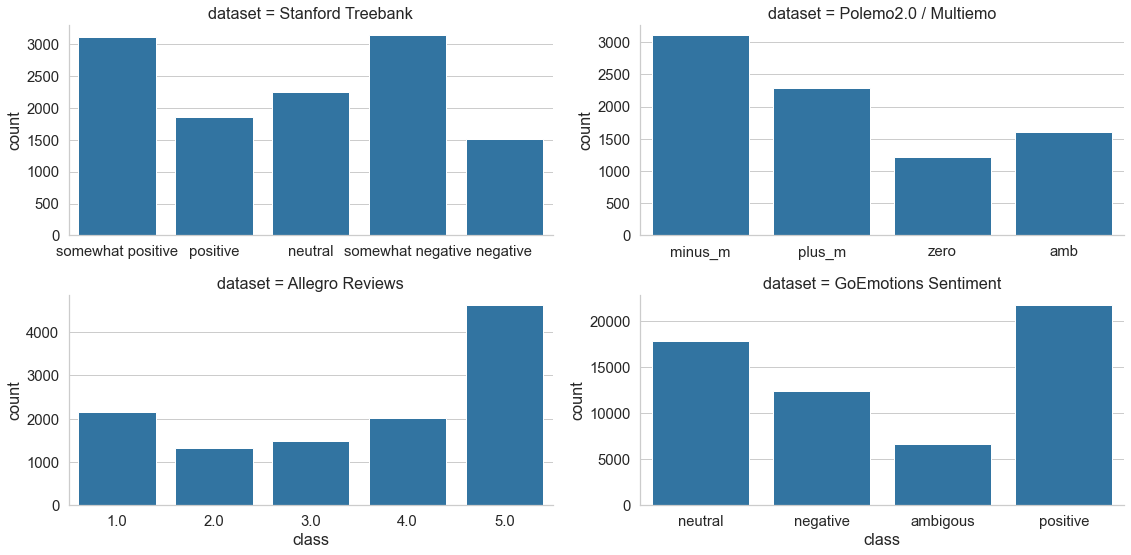

In [61]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

with sns.plotting_context("notebook", font_scale=1.35):
    g = sns.FacetGrid(
        df_class_grid,
        col="dataset",
        col_wrap=2,
        sharey=False,
        sharex=False,
        height=4,
        aspect=2,
    )
    g.map(sns.countplot, 'class')

sns.despine()

In [62]:
g.savefig(FIGURE_DIR.joinpath('sentiment_data_class_distribution.png'), dpi=300)

## Token amount distribution

In [3]:
from transformers import AutoTokenizer


def get_tokens_len(df: pd.DataFrame, tokenizer_name: str) -> pd.DataFrame:
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, do_lower_case=True)
    texts = df['text'].values.tolist()

    text_tokenized = tokenizer(
        texts,
        add_special_tokens=True,
        return_token_type_ids=False,
        return_attention_mask=False,
        truncation=False,
        padding=False,
        return_length=True
    )
    lengths = text_tokenized['length']

    df['tok_length'] = lengths
    return df

In [106]:
df_imdb = get_tokens_len(df=df_imdb, tokenizer_name='bert-base-cased')
df_movie = get_tokens_len(df=df_movie, tokenizer_name='bert-base-cased')
df_sst = get_tokens_len(df=df_sst, tokenizer_name='bert-base-cased')
df_polemo = get_tokens_len(df=df_polemo, tokenizer_name='allegro/herbert-base-cased')
df_klej = get_tokens_len(df=df_klej, tokenizer_name='allegro/herbert-base-cased')
df_goemo_sent = get_tokens_len(df=df_goemo_sent, tokenizer_name='bert-base-cased')
df_goemo = get_tokens_len(df=df_goemo, tokenizer_name='bert-base-cased')

Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (571 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1669 > 512). Running this sequence through the model will result in indexing errors


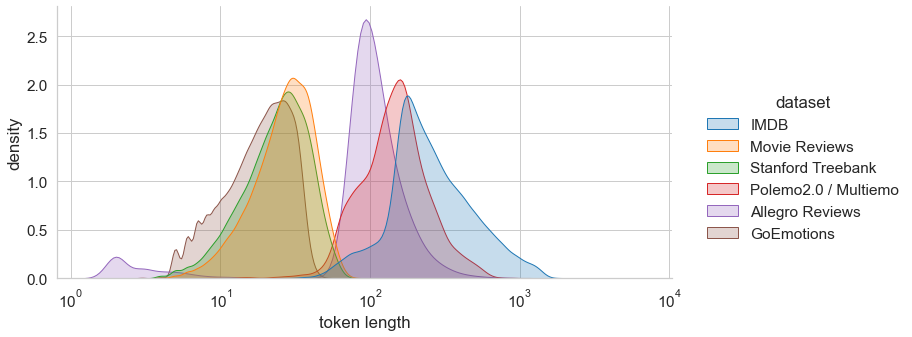

In [107]:
sns.set_style("whitegrid")
df_tokens_line = pd.concat([
    df_imdb,
    df_movie,
    df_sst,
    df_polemo,
    df_klej,
    df_goemo,
],
    ignore_index=True,
)
with sns.plotting_context("notebook", font_scale=1.4):
    fig = sns.displot(
        df_tokens_line,
        x="tok_length",
        hue="dataset",
        log_scale=True,
        common_norm=False,
        kind="kde",
        fill=True,
        height=5,
        aspect=2,
    )
    sns.despine()
    fig.set(xlabel='token length', ylabel='density')
fig.savefig(FIGURE_DIR.joinpath('data_token_len_distplot.png'), dpi=300)

## Annotations coverage

In [9]:
from typing import Optional
from collections import defaultdict
from tqdm.auto import tqdm
from pathlib import Path
import json


def load_json_data(path: Path, split: str, lang: str) -> dict:
    json_path = path.joinpath(
        f'wsd_amuse_{lang.upper()}', f'{split}.amuse_wsd.json'
    )

    with json_path.open(mode='r') as f:
        return json.load(f)


def load_polemo_json_data(path: Path, split: str, lang: str, domain: str = 'all', mode: str = 'text') -> dict:
    json_path = path.joinpath(
        f'wsd_amuse_{lang.upper()}',
        f'{domain}_{mode}.{split}.amuse_wsd.json',
    )

    with json_path.open(mode='r') as f:
        return json.load(f)


def calculate_ann_stats(data: dict, stats_dict: Optional[dict] = None) -> dict:
    if not stats_dict:
        stats_dict = defaultdict(int)

    for sample_id in tqdm(data.keys(), total=len(data.keys())):
        sample = data[sample_id]
        tokens = sample['tokens']

        stats_dict['all_tokens'] += len(tokens)

        for token in tokens:
            # sentiment annotation
            if 'sentiwordnetScore' in token:
                stats_dict['sentiPWN_annotated'] += 1
                sent_score = float(token['sentiwordnetScore'])
                if sent_score > 0.0:
                    stats_dict['sentiPWN_pos_annotated'] += 1
                if sent_score < 0.0:
                    stats_dict['sentiPWN_neg_annotated'] += 1

            if 'plwnSentimentScore' in token:
                stats_dict['sentiPL_annotated'] += 1
                sent_score = float(token['plwnSentimentScore'])
                if sent_score > 0.0:
                    stats_dict['sentiPL_pos_annotated'] += 1
                if sent_score < 0.0:
                    stats_dict['sentiPL_neg_annotated'] += 1

            # basic emotions
            if 'plwnEmotionNames' in token:
                stats_dict['basic_emo_annotated'] += 1

            if 'plwnEmotionValuations' in token:
                stats_dict['emo_valuations_annotated'] += 1

    return stats_dict


def get_total_splits_stats(path: Path, lang: str) -> dict:
    splits = ['train', 'dev', 'test']
    stats_dict = defaultdict(int)

    if 'polemo2' in path.__str__():
        for split_name in splits:
            data = load_polemo_json_data(path=path, split=split_name, lang=lang, mode='text', domain='all')
            stats_dict = calculate_ann_stats(data, stats_dict=stats_dict)
    else:
        for split_name in splits:
            data = load_json_data(path=path, split=split_name, lang=lang)
            stats_dict = calculate_ann_stats(data, stats_dict=stats_dict)

    # get percentage
    all_tokens = stats_dict.pop('all_tokens')
    for key in stats_dict.keys():
        stats_dict[key] = stats_dict[key] / all_tokens * 100

    return dict(stats_dict)

In [10]:
imdb_stats = get_total_splits_stats(path=IMDB_DIR, lang='en')
imdb_stats['dataset'] = 'IMDB'

mr_stats = get_total_splits_stats(path=MOVIE_REVIEWS_DIR, lang='en')
mr_stats['dataset'] = 'Movie Reviews'

sst_stats = get_total_splits_stats(path=SST_DIR, lang='en')
sst_stats['dataset'] = 'Stanford Treebank'

polemo_stats = get_total_splits_stats(path=POLEMO_DIR, lang='pl')
polemo_stats['dataset'] = 'Polemo2.0'

multiemo_stats = get_total_splits_stats(path=MULTIEMO_DIR, lang='en')
multiemo_stats['dataset'] = 'Multiemo'

klej_stats = get_total_splits_stats(path=KLEJ_AR_DIR, lang='pl')
klej_stats['dataset'] = 'Allegro Reviews'

goemo_stats = get_total_splits_stats(path=GOEMOTIONS_DIR, lang='en')
goemo_stats['dataset'] = 'GoEmotions'

  0%|          | 0/22500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/8534 [00:00<?, ?it/s]

  0%|          | 0/1078 [00:00<?, ?it/s]

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/8544 [00:00<?, ?it/s]

  0%|          | 0/1101 [00:00<?, ?it/s]

  0%|          | 0/2210 [00:00<?, ?it/s]

  0%|          | 0/6573 [00:00<?, ?it/s]

  0%|          | 0/823 [00:00<?, ?it/s]

  0%|          | 0/820 [00:00<?, ?it/s]

  0%|          | 0/6571 [00:00<?, ?it/s]

  0%|          | 0/823 [00:00<?, ?it/s]

  0%|          | 0/820 [00:00<?, ?it/s]

  0%|          | 0/9180 [00:00<?, ?it/s]

  0%|          | 0/977 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

In [11]:
records = [
    imdb_stats,
    mr_stats,
    sst_stats,
    polemo_stats,
    multiemo_stats,
    klej_stats,
    goemo_stats,
]

df_annotation = pd.DataFrame.from_records(records)

df_annotation

,sentiPWN_annotated,sentiPWN_pos_annotated,sentiPL_annotated,basic_emo_annotated,emo_valuations_annotated,sentiPL_neg_annotated,sentiPWN_neg_annotated,sentiPL_pos_annotated,dataset
0,44.903903,12.029989,27.495093,22.999473,23.348909,3.491029,5.410353,3.890759,IMDB
1,52.304502,14.386236,32.052682,26.494000,26.781171,4.965447,7.153653,5.604863,Movie Reviews
2,47.981078,13.927566,29.270012,24.842779,25.169323,4.479463,6.790320,5.281171,Stanford Treebank
3,48.114186,8.278033,31.511766,24.547738,25.093988,2.927840,5.871436,3.759811,Polemo2.0
4,45.037088,10.500268,28.632181,22.753029,23.162679,2.276114,5.042859,3.324809,Multiemo
5,47.896060,8.323963,28.178008,22.421987,22.708705,2.817179,5.995238,3.717823,Allegro Reviews
6,45.762315,12.485521,25.895597,24.935463,25.242309,3.530498,5.939874,3.794082,GoEmotions
